# Multi-label learning, part 2

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gmixo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load training and test data

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [3]:
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\r\n\r\nCongratulations from me as well, use ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In the training data, the comments are labelled as one or more of the six categories; toxic, severe toxic, obscene, threat, insult and identity hate. This is essentially a multi-label classification problem.

In [4]:
cols_target = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are no missing numeric values. As the mean values are very small (some way below 0.05), there would be many not labelled as positive in the six categories. From this I guess that there would be many comments which are not labelled in any of the six categories. Let's take a look.

In [5]:
labeled_cond = train_df[cols_target].T.any()
unlabelled_in_all = train_df[~labeled_cond]

print('Percentage of unlabelled comments is ', len(unlabelled_in_all) / len(train_df) * 100)

Percentage of unlabelled comments is  89.83211235124176


In [6]:
# check for any 'null' comment in train set
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [7]:
# check for any null comment in test set
no_comment_test = test_df[test_df['comment_text'].isnull()]
len(no_comment)

0

In [8]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [9]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

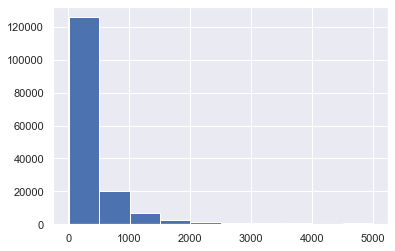

In [10]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.

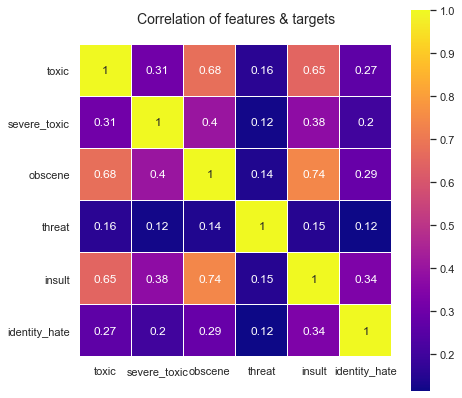

In [11]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(train_df[cols_target].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
            linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

What about the character length & distribution of the comment text in the test data?

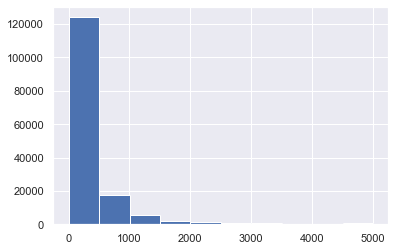

In [12]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

Now, the shape of character length distribution looks similar between the training data and the test data. For the training data, I guess the test data were clipped to 5,000 characters to facilitate the folks who did the labelling of the comment categories.

In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    ### removing 
    text = re.sub('\W', ' ', text)
    ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('[^A-Za-z\' ]+', '',text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    ### Stopwords removal
    text = ' '.join([word for word in text.split() if word not in(stop_words)])
    return text

In [14]:
# clean the comment_text in train_df 
train_df['comment_text'] = train_df['comment_text'].map(clean_text)
# clean the comment_text in test_df 
#test_df['comment_text'] = test_df['comment_text'].map(clean_text)

In [15]:
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,char_length
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,265
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,112
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,233
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0,626
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,67
5,00025465d4725e87,congratulations well use tools well talk,0,0,0,0,0,0,67
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,44
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0,115
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0,472
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0,70


In [16]:
train_df = train_df.drop('char_length',axis=1)

In [17]:
# filter comments with no labels
from sklearn.model_selection import train_test_split
X_train = train_df[labeled_cond].comment_text
y_train = train_df[labeled_cond][cols_target]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42)
#X_test = test_df.comment_text
#test_df.head()
print(X_test.shape, X_train.shape)

(4057,) (12168,)


Vectorize data

In [18]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

vect

TfidfVectorizer(max_features=10000, stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [19]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_train_tf = vect.fit_transform(X_train)
# examine the document-term matrix created from X_train
X_train_tf

<12168x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 179846 stored elements in Compressed Sparse Row format>

In [20]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
X_test_tf = vect.transform(X_test)
# examine the document-term matrix from X_test
X_test_tf

<4057x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 58187 stored elements in Compressed Sparse Row format>

## Multi-label toxic comment classification

### Classifier chain

In [21]:
from sklearn.svm import SVC
from skmultilearn.problem_transform import ClassifierChain
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [22]:
parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [10, 20, 50],
    },
]


classifier = GridSearchCV(ClassifierChain(), parameters, scoring="accuracy")
classifier.fit(X_train_tf,y_train)

GridSearchCV(estimator=ClassifierChain(require_dense=[True, True]),
             param_grid=[{'classifier': [MultinomialNB()],
                          'classifier__alpha': [0.7, 1.0]},
                         {'classifier': [RandomForestClassifier(criterion='entropy',
                                                                n_estimators=50)],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__n_estimators': [10, 20, 50]}],
             scoring='f1_samples')

In [27]:
# predict on train data because we do not have labels on test data
y_predicted_train = classifier.predict(X_train_tf)
y_pred_test = classifier.predict(X_test_tf)


In [28]:
# accuracy
print (classifier.best_params_, classifier.best_score_)
print("Training accuracy:", metrics.accuracy_score(y_train.to_numpy(), y_predicted_train.todense()))

{'classifier': RandomForestClassifier(criterion='entropy', n_estimators=50), 'classifier__criterion': 'entropy', 'classifier__n_estimators': 50} 0.8153133563278276
Training accuracy: 0.9835634451019066


Let's take a look at a sample

Let's examine the metrics for each label using the classification report.

In [39]:
print(metrics.classification_report(y_test, y_pred_test))
print(metrics.multilabel_confusion_matrix(y_test, y_pred_test))
print(metrics.precision_recall_fscore_support(y_test,y_pred_test,average="samples"))

print('Hamming:', metrics.hamming_loss(y_test, y_pred_test))
print('roc auc:', metrics.roc_auc_score(y_test,y_pred_test.todense(),average="macro")) 
report = metrics.classification_report(y_test, y_pred_test, target_names=cols_target, output_dict=True)
d=pd.DataFrame(report).transpose()
d.to_excel("chainf1.xlsx")

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3810
           1       0.49      0.07      0.13       418
           2       0.85      0.79      0.82      2127
           3       0.62      0.08      0.14       129
           4       0.72      0.66      0.69      2022
           5       0.70      0.19      0.30       378

   micro avg       0.86      0.78      0.82      8884
   macro avg       0.72      0.46      0.51      8884
weighted avg       0.83      0.78      0.79      8884
 samples avg       0.87      0.82      0.81      8884

[[[   1  246]
  [   5 3805]]

 [[3608   31]
  [ 388   30]]

 [[1643  287]
  [ 447 1680]]

 [[3922    6]
  [ 119   10]]

 [[1514  521]
  [ 685 1337]]

 [[3648   31]
  [ 306   72]]]
(0.8743652945526251, 0.8153890395201709, 0.8080579910873232, None)
Hamming: 0.1262016268178457
roc auc: 0.6141980559861078


Alternately, we can do that using a Logistic regression model.

### Label Powerset

In [29]:
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import LabelPowerset

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
        
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['sigmoid', 'linear'],
        
    },
]

classifier = GridSearchCV(LabelPowerset(),parameters,scoring='accuracy')

In [41]:
# predict on train data because we do not have labels on test data
classifier.fit(X_train_tf,y_train)
print (classifier.best_params_, classifier.best_score_)

{'classifier': SVC(kernel='linear'), 'classifier__kernel': 'linear'} 0.8019643230051067


In [42]:
# accuracy
y_predicted_train = classifier.predict(X_train_tf)
y_pred_test = classifier.predict(X_test_tf)
print("Training accuracy:", metrics.accuracy_score(y_train.to_numpy(), y_predicted_train.todense()))

Training accuracy: 0.6682281393819856


Let's take a look at the first sample once more

In [32]:
print('Message: "' + X_test[0] + '"')
print([cols_target[i] for i in np.where(classifier.predict(X_test_tf[0]).todense() == 1)[1]])

Message: "yo bitch ja rule succesful ever whats hating sad mofuckas bitch slap ur pethedic white faces get kiss ass guys sicken ja rule pride da music man dont diss shit nothin wrong bein like tupac brother fuckin white boys get things right next time"
['toxic', 'obscene', 'insult']


Let's examine the metrics for each label using the classification report.

In [51]:
print(metrics.classification_report(y_test, y_pred_test))
print(metrics.multilabel_confusion_matrix(y_test, y_pred_test))
print(metrics.precision_recall_fscore_support(y_test,y_pred_test,average="samples"))
#print("F1: ",metrics.f1_score(y_test,y_pred_test,average="macro"))

print('Hamming:', metrics.hamming_loss(y_test, y_pred_test))
#print('roc auc:', metrics.roc_auc_score(y_test,y_pred_test.todense(),average="macro")) 
#report = metrics.classification_report(y_test, y_pred_test, target_names=cols_target, output_dict=True)
#d=pd.DataFrame(report).transpose()
#d.to_excel("labelf1.xlsx")

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3810
           1       0.53      0.13      0.21       418
           2       0.88      0.68      0.77      2127
           3       0.77      0.13      0.23       129
           4       0.77      0.58      0.66      2022
           5       0.79      0.21      0.33       378

   micro avg       0.88      0.74      0.81      8884
   macro avg       0.78      0.45      0.53      8884
weighted avg       0.86      0.74      0.78      8884
 samples avg       0.89      0.78      0.80      8884

[[[   0  247]
  [   0 3810]]

 [[3592   47]
  [ 364   54]]

 [[1727  203]
  [ 682 1445]]

 [[3923    5]
  [ 112   17]]

 [[1682  353]
  [ 847 1175]]

 [[3658   21]
  [ 300   78]]]
(0.8931764029249856, 0.77757374085942, 0.7950152783157466, None)
F1:  0.5260733073015018
Hamming: 0.13067948401939036


Alternately, we can do that using a Logistic regression model.